# Implement the SepHeads (trained on MHS) + boundary combined model

__Objective:__ evaluate a model that takes the predictions from a SepHeads  model (fine-tuned on the MHS dataset) and combines them with those of the boundary model, with the latter overriding the former based on a confidence score.

The above can be achieved just at the prediction level (without actually combining models), or at the full model level.

**Prediction level**

Inputs:
- Predictions from the SepHeads model.
- Predictions from the boundary model (for the same samples), with confidence scores.
- A confidence score threshold (hyperparameter - set by the user).

Output:
- The prediction from SepHeads, if the boundary model's confidence score for that sample is below the threshold, otherwise the prediction from the boundary model.

Implementation: a function.

**Model level**

Input:
- Input sample (text).
- Confidence threshold.

Output:
- Predictions, either from the SepHeads model or the boundary one, according to the same logic as above.

Implementation: new model, taking a fine-tuned SepHeads model and a confidence threshold as the input to the constructor, and performing a call to GPT internally.

In [1]:
import sys
import pandas as pd
import numpy as np
import pickle
import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

sys.path.append('../../modules/')

from model_utils import compute_combined_prediction

sns.set_theme()

%load_ext autoreload
%autoreload 2

## MHS dataset

### Load data

Load the MHS test data and the predictions from SepHeads.

In [2]:
MHS_TRAIN_DATA_PATH = '/data1/moscato/personalised-hate-boundaries-data/data/measuring_hate_speech_data_clean/mhs_clean_train.csv'
MHS_TEST_DATA_PATH = '/data1/moscato/personalised-hate-boundaries-data/data/measuring_hate_speech_data_clean/mhs_clean_test.csv'

ANNOTATORS_DATA_PATH = '/data1/moscato/personalised-hate-boundaries-data/data/measuring_hate_speech_data_clean/annotators_data_mhs.csv'

SEPHEADS_HMS_PREDICTED_LOGITS_OUTPUT_PATH = '/data1/moscato/personalised-hate-boundaries-data/models/mhs/sepheads_model_training_mhs_test_2/checkpoint_1611_mhs_predicted_logits.pkl'

BOUNDARY_MODEL_HMS_PREDS_PATH = '/data1/moscato/personalised-hate-boundaries-data/data/boundary_model_predictions/paul_default_mhs_fullpredictions.csv'

In [6]:
# Load test data.
mhs_test_data = pd.read_csv(MHS_TEST_DATA_PATH).drop(columns=['extreme_annotator'])

# Load annotators data.
annotators_data = pd.read_csv(ANNOTATORS_DATA_PATH)

# Load SepHeads predictions.
with open(SEPHEADS_HMS_PREDICTED_LOGITS_OUTPUT_PATH, 'rb') as f:
    predicted_logits = pickle.load(f)
    
sepheads_mhs_predicted_toxic_score = predicted_logits.argmax(axis=-1)

# Load boundary model predictions.
boundary_model_preds = pd.read_csv(BOUNDARY_MODEL_HMS_PREDS_PATH).rename(
    columns={'prediction': 'boundary_model_predicted_toxic_score'}
)

# Add SepHeads predictions to test data.
mhs_test_data['sepheads_predicted_toxic_score'] = sepheads_mhs_predicted_toxic_score

# Merge test data with boundary model predictions.
mhs_test_data = pd.merge(
    left=mhs_test_data,
    right=boundary_model_preds[['text_id', 'boundary_model_predicted_toxic_score', 'confidence_score']],
    how='left',
    on='text_id'
)

# Merge test data with annotators data (to get the extreme annotator label).
mhs_test_data = pd.merge(
    left=mhs_test_data,
    right=annotators_data[['annotator_id', 'extreme_annotator']],
    on='annotator_id',
    how='left'
)

# Compute majority-vote labels and add them to the data.
mhs_test_data = pd.merge(
    left=mhs_test_data,
    right=mhs_test_data.groupby('text_id')['toxic_score'].apply(
        lambda g: g.value_counts(ascending=False).index[0]
    ).rename('majority_vote_toxic_score').reset_index(),
    on='text_id',
    how='left'
)

mhs_test_data

,text_id,annotator_id,toxic_score,text,sepheads_predicted_toxic_score,boundary_model_predicted_toxic_score,confidence_score,extreme_annotator,majority_vote_toxic_score
0,29107,1671,0,Fuck a bitch named Uterus.,1,1,85,False,1
1,40501,146,1,no one fucking cares fag,1,1,95,False,1
2,20599,4719,1,You criminals have perfected this art of media...,0,1,85,False,0
3,33260,3475,0,7/22/19: Israeli soldiers and border police bl...,0,0,85,True,0
4,18799,5341,0,Forget about them lets start a holocaust and k...,1,1,100,False,0
...,...,...,...,...,...,...,...,...,...
2252,20063,5649,0,"Lady in the back Blinks when ""her"" camera red ...",0,1,85,False,0
2253,20063,2655,0,"Lady in the back Blinks when ""her"" camera red ...",0,1,85,False,0
2254,20067,1666,0,"Please help support nonbinary pride, add a #Tw...",0,0,95,False,0
2255,20063,7017,0,"Lady in the back Blinks when ""her"" camera red ...",0,1,85,False,0


In [9]:
mhs_training_data = pd.read_csv(MHS_TRAIN_DATA_PATH).drop(columns=['extreme_annotator'])

mhs_training_data = pd.merge(
    left=mhs_training_data,
    right=annotators_data[['annotator_id', 'extreme_annotator']],
    on='annotator_id',
    how='left'
)

mhs_merged_data = pd.concat([
    mhs_training_data,
    mhs_test_data[mhs_training_data.columns]
]).reset_index(drop=True)

mhs_merged_data

,text_id,annotator_id,toxic_score,text,extreme_annotator
0,20583,7259,0,@terryelaineh1 @UKLabour Why do 3.8 million #5...,False
1,5410,123,0,Them - DON'T YOU DARE OBJECTIFY US!! ​ Also th...,False
2,5611,6998,0,Well this explains all the Muslim people I saw...,False
3,12271,415,0,You get to fuck her and get fucked in the ass ...,False
4,47899,3538,1,i almost puke seeing this transvestite,False
...,...,...,...,...,...
7954,20063,5649,0,"Lady in the back Blinks when ""her"" camera red ...",False
7955,20063,2655,0,"Lady in the back Blinks when ""her"" camera red ...",False
7956,20067,1666,0,"Please help support nonbinary pride, add a #Tw...",False
7957,20063,7017,0,"Lady in the back Blinks when ""her"" camera red ...",False


In [11]:
mhs_merged_data['text_id'].unique().shape

(2005,)

In [13]:
mhs_merged_data.groupby('text_id')['annotator_id'].count().mean()

np.float64(3.969576059850374)

In [14]:
mhs_merged_data['annotator_id'].unique().shape

(545,)

In [16]:
mhs_merged_data.groupby('annotator_id')['text_id'].count().mean()

np.float64(14.603669724770642)

In [18]:
(
    mhs_training_data.groupby('annotator_id')['extreme_annotator'].first().sum(),
    mhs_test_data.groupby('annotator_id')['extreme_annotator'].first().sum()
)

(np.int64(62), np.int64(62))

In [19]:
mhs_training_data['toxic_score'].mean()

np.float64(0.3416345142055419)

### Evaluate the combined model

#### Metrics against annotator-level ground truth

In [42]:
classification_metrics_hms = []
classification_metrics_extreme_annotators_hms = []
classification_metrics_nonextreme_annotators_hms = []

for confidence_threshold in np.arange(70, 106, 5):
    # All annotators
    combined_preds = compute_combined_prediction(
        sepheads_preds=mhs_test_data['sepheads_predicted_toxic_score'],
        boundary_model_preds=mhs_test_data['boundary_model_predicted_toxic_score'],
        confidence_scores=mhs_test_data['confidence_score'],
        confidence_threshold=confidence_threshold
    )
    
    mhs_test_data[f'combined_predicted_toxic_score_confidence_{confidence_threshold}'] = combined_preds

    cr = classification_report(
        mhs_test_data['toxic_score'],
        combined_preds,
        digits=3,
        output_dict=True
    )

    overridden_preds_frac = (
        mhs_test_data[f'combined_predicted_toxic_score_confidence_{confidence_threshold}']
        != mhs_test_data['sepheads_predicted_toxic_score']
    ).mean()

    classification_metrics_hms.append({
        'confidence_threshold': confidence_threshold,
        'overridden_preds_frac': overridden_preds_frac,
        'accuracy': cr['accuracy'],
        **cr['macro avg']
    })

    # Extreme annotators.
    cr = classification_report(
        mhs_test_data[mhs_test_data['extreme_annotator']]['toxic_score'],
        mhs_test_data[mhs_test_data['extreme_annotator']][f'combined_predicted_toxic_score_confidence_{confidence_threshold}'],
        digits=3,
        output_dict=True
    )

    overridden_preds_frac = (
        mhs_test_data[mhs_test_data['extreme_annotator']][f'combined_predicted_toxic_score_confidence_{confidence_threshold}']
        != mhs_test_data[mhs_test_data['extreme_annotator']]['sepheads_predicted_toxic_score']
    ).mean()

    classification_metrics_extreme_annotators_hms.append({
        'confidence_threshold': confidence_threshold,
        'overridden_preds_frac': overridden_preds_frac,
        'accuracy': cr['accuracy'],
        **cr['macro avg']
    })

    # Non-extreme annotators.
    cr = classification_report(
        mhs_test_data[~mhs_test_data['extreme_annotator']]['toxic_score'],
        mhs_test_data[~mhs_test_data['extreme_annotator']][f'combined_predicted_toxic_score_confidence_{confidence_threshold}'],
        digits=3,
        output_dict=True
    )

    overridden_preds_frac = (
        mhs_test_data[~mhs_test_data['extreme_annotator']][f'combined_predicted_toxic_score_confidence_{confidence_threshold}']
        != mhs_test_data[~mhs_test_data['extreme_annotator']]['sepheads_predicted_toxic_score']
    ).mean()

    classification_metrics_nonextreme_annotators_hms.append({
        'confidence_threshold': confidence_threshold,
        'overridden_preds_frac': overridden_preds_frac,
        'accuracy': cr['accuracy'],
        **cr['macro avg']
    })

classification_metrics_hms = pd.DataFrame(classification_metrics_hms)
classification_metrics_extreme_annotators_hms = pd.DataFrame(classification_metrics_extreme_annotators_hms)
classification_metrics_nonextreme_annotators_hms = pd.DataFrame(classification_metrics_nonextreme_annotators_hms)

In [43]:
display(classification_metrics_hms)
display(classification_metrics_extreme_annotators_hms)
display(classification_metrics_nonextreme_annotators_hms)

,confidence_threshold,overridden_preds_frac,accuracy,precision,recall,f1-score,support
0,70,0.357997,0.753212,0.816155,0.768983,0.746770,2257.0
1,75,0.357997,0.753212,0.816155,0.768983,0.746770,2257.0
2,80,0.357997,0.753212,0.816155,0.768983,0.746770,2257.0
3,85,0.357997,0.753212,0.816155,0.768983,0.746770,2257.0
4,90,0.216216,0.846256,0.854400,0.852106,0.846208,2257.0
5,95,0.210456,0.848471,0.855364,0.853910,0.848450,2257.0
6,100,0.010634,0.797519,0.815334,0.787997,0.790112,2257.0
7,105,0.000000,0.787771,0.808270,0.777415,0.779067,2257.0


,confidence_threshold,overridden_preds_frac,accuracy,precision,recall,f1-score,support
0,70,0.379182,0.698885,0.757485,0.778689,0.697816,269.0
1,75,0.379182,0.698885,0.757485,0.778689,0.697816,269.0
2,80,0.379182,0.698885,0.757485,0.778689,0.697816,269.0
3,85,0.379182,0.698885,0.757485,0.778689,0.697816,269.0
4,90,0.215613,0.817844,0.804655,0.847630,0.808307,269.0
5,95,0.211896,0.821561,0.807461,0.850362,0.811888,269.0
6,100,0.018587,0.836431,0.824623,0.787330,0.801383,269.0
7,105,0.000000,0.825279,0.816667,0.766806,0.783647,269.0


,confidence_threshold,overridden_preds_frac,accuracy,precision,recall,f1-score,support
0,70,0.355131,0.760563,0.822484,0.767931,0.751681,1988.0
1,75,0.355131,0.760563,0.822484,0.767931,0.751681,1988.0
2,80,0.355131,0.760563,0.822484,0.767931,0.751681,1988.0
3,85,0.355131,0.760563,0.822484,0.767931,0.751681,1988.0
4,90,0.216298,0.850101,0.858929,0.852819,0.849720,1988.0
5,95,0.210262,0.852113,0.859629,0.854627,0.851822,1988.0
6,100,0.009557,0.792254,0.811693,0.787824,0.787042,1988.0
7,105,0.000000,0.782696,0.804616,0.777928,0.776539,1988.0


In [44]:
# test_data.to_csv(
#     '/data1/moscato/personalised-hate-boundaries-data/data/boundary_model_predictions/combined_preds_kumar_test_data_subsampled.csv',
#     index=None
# )

Text(0.5, 1.0, 'Non-extreme annotators')

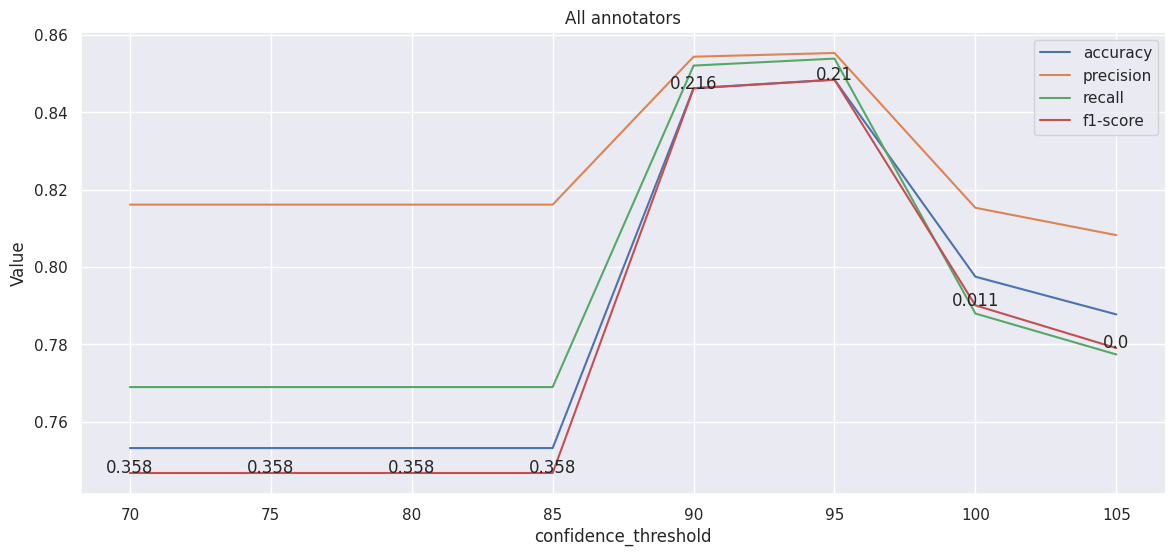

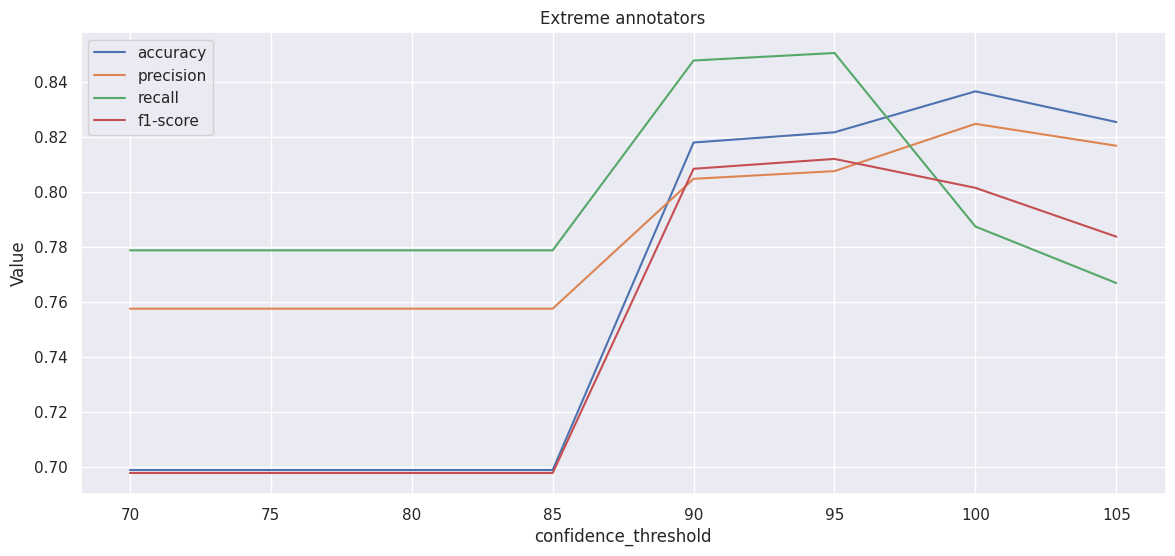

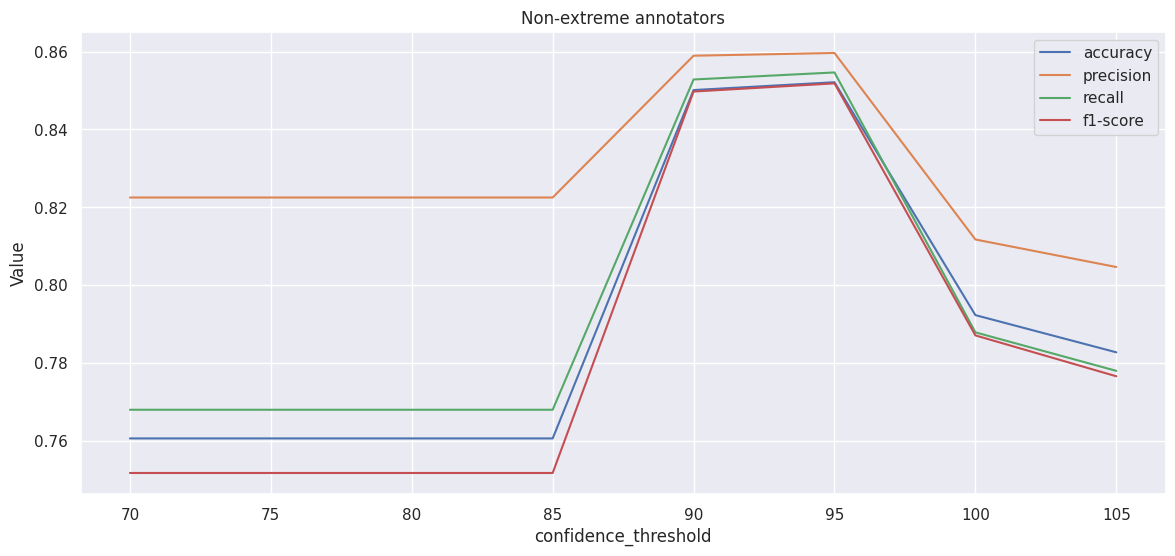

In [45]:
# All annotators.
fig = plt.figure(figsize=(14, 6))

for metric in ['accuracy', 'precision', 'recall', 'f1-score']:
    sns.lineplot(
        x=classification_metrics_hms['confidence_threshold'],
        y=classification_metrics_hms[metric],
        label=metric
    )

for i, row in classification_metrics_hms[['overridden_preds_frac', 'confidence_threshold', metric]].iterrows():
    plt.text(
        row['confidence_threshold'],
        row[metric],
        row['overridden_preds_frac'].round(3),
        horizontalalignment="center"
    )

plt.legend()
plt.ylabel('Value')
plt.title('All annotators')


# Extreme annotators.
fig = plt.figure(figsize=(14, 6))

for metric in ['accuracy', 'precision', 'recall', 'f1-score']:
    sns.lineplot(
        x=classification_metrics_extreme_annotators_hms['confidence_threshold'],
        y=classification_metrics_extreme_annotators_hms[metric],
        label=metric
    )

plt.legend()
plt.ylabel('Value')
plt.title('Extreme annotators')


# Non-extreme annotators.
fig = plt.figure(figsize=(14, 6))

for metric in ['accuracy', 'precision', 'recall', 'f1-score']:
    sns.lineplot(
        x=classification_metrics_nonextreme_annotators_hms['confidence_threshold'],
        y=classification_metrics_nonextreme_annotators_hms[metric],
        label=metric
    )

plt.legend()
plt.ylabel('Value')
plt.title('Non-extreme annotators')

Text(0.5, 1.0, 'F1-scores against annotator-level labels (MHS data)')

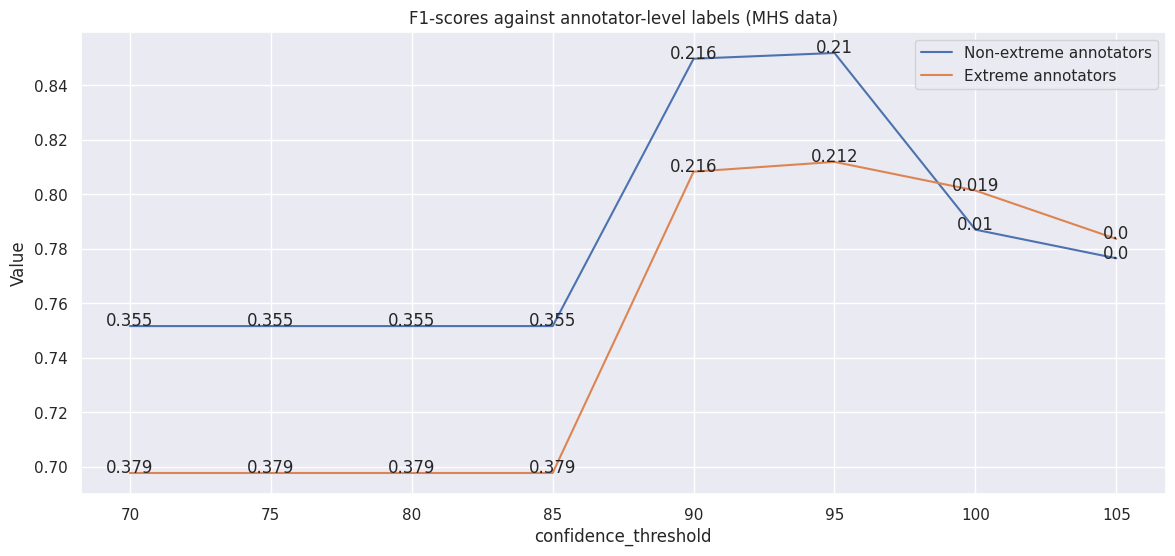

In [46]:
fig = plt.figure(figsize=(14, 6))

# sns.lineplot(
#     x=classification_metrics_kumar['confidence_threshold'],
#     y=classification_metrics_kumar['f1-score'],
#     label='All annotators'
# )

sns.lineplot(
    x=classification_metrics_nonextreme_annotators_hms['confidence_threshold'],
    y=classification_metrics_nonextreme_annotators_hms['f1-score'],
    label='Non-extreme annotators'
)

for i, row in classification_metrics_nonextreme_annotators_hms[['overridden_preds_frac', 'confidence_threshold', metric]].iterrows():
    plt.text(
        row['confidence_threshold'],
        row[metric],
        row['overridden_preds_frac'].round(3),
        horizontalalignment="center"
    )

sns.lineplot(
    x=classification_metrics_extreme_annotators_hms['confidence_threshold'],
    y=classification_metrics_extreme_annotators_hms['f1-score'],
    label='Extreme annotators'
)

for i, row in classification_metrics_extreme_annotators_hms[['overridden_preds_frac', 'confidence_threshold', metric]].iterrows():
    plt.text(
        row['confidence_threshold'],
        row[metric],
        row['overridden_preds_frac'].round(3),
        horizontalalignment="center"
    )

plt.legend()
plt.ylabel('Value')
plt.title('F1-scores against annotator-level labels (MHS data)')

#### Metrics against majority-vote ground truth labels

In [47]:
classification_metrics_mhs_majority_vote_labels = []
classification_metrics_extreme_annotators_mhs_majority_vote_labels = []
classification_metrics_nonextreme_annotators_mhs_majority_vote_labels = []

for confidence_threshold in np.arange(70, 106, 5):
    cr = classification_report(
        mhs_test_data['majority_vote_toxic_score'],
        mhs_test_data[f'combined_predicted_toxic_score_confidence_{confidence_threshold}'],
        digits=3,
        output_dict=True
    )

    overridden_preds_frac = (
        mhs_test_data[f'combined_predicted_toxic_score_confidence_{confidence_threshold}']
        != mhs_test_data['sepheads_predicted_toxic_score']
    ).mean()

    classification_metrics_mhs_majority_vote_labels.append({
        'confidence_threshold': confidence_threshold,
        'overridden_preds_frac': overridden_preds_frac,
        'accuracy': cr['accuracy'],
        **cr['macro avg']
    })

    # Extreme annotators.
    cr = classification_report(
        mhs_test_data[mhs_test_data['extreme_annotator']]['majority_vote_toxic_score'],
        mhs_test_data[mhs_test_data['extreme_annotator']][f'combined_predicted_toxic_score_confidence_{confidence_threshold}'],
        digits=3,
        output_dict=True
    )

    overridden_preds_frac = (
        mhs_test_data[mhs_test_data['extreme_annotator']][f'combined_predicted_toxic_score_confidence_{confidence_threshold}']
        != mhs_test_data[mhs_test_data['extreme_annotator']]['sepheads_predicted_toxic_score']
    ).mean()

    classification_metrics_extreme_annotators_mhs_majority_vote_labels.append({
        'confidence_threshold': confidence_threshold,
        'overridden_preds_frac': overridden_preds_frac,
        'accuracy': cr['accuracy'],
        **cr['macro avg']
    })

    # Non-extreme annotators.
    cr = classification_report(
        mhs_test_data[~mhs_test_data['extreme_annotator']]['majority_vote_toxic_score'],
        mhs_test_data[~mhs_test_data['extreme_annotator']][f'combined_predicted_toxic_score_confidence_{confidence_threshold}'],
        digits=3,
        output_dict=True
    )

    overridden_preds_frac = (
        mhs_test_data[~mhs_test_data['extreme_annotator']][f'combined_predicted_toxic_score_confidence_{confidence_threshold}']
        != mhs_test_data[~mhs_test_data['extreme_annotator']]['sepheads_predicted_toxic_score']
    ).mean()

    classification_metrics_nonextreme_annotators_mhs_majority_vote_labels.append({
        'confidence_threshold': confidence_threshold,
        'overridden_preds_frac': overridden_preds_frac,
        'accuracy': cr['accuracy'],
        **cr['macro avg']
    })

classification_metrics_mhs_majority_vote_labels = pd.DataFrame(classification_metrics_mhs_majority_vote_labels)
classification_metrics_extreme_annotators_mhs_majority_vote_labels = pd.DataFrame(classification_metrics_extreme_annotators_mhs_majority_vote_labels)
classification_metrics_nonextreme_annotators_mhs_majority_vote_labels = pd.DataFrame(classification_metrics_nonextreme_annotators_mhs_majority_vote_labels)

Text(0.5, 1.0, 'Non-extreme annotators')

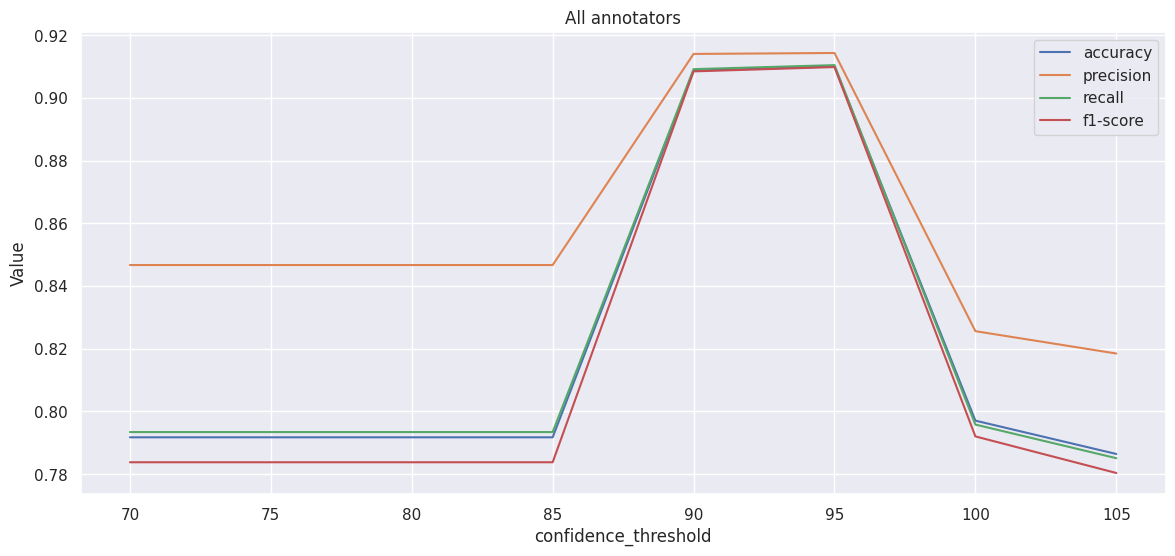

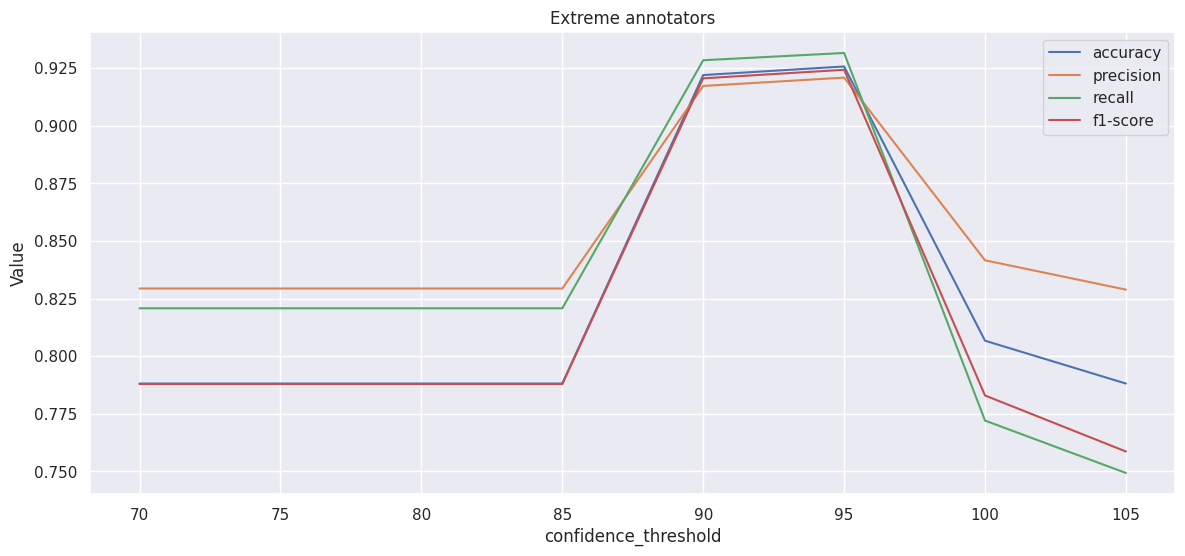

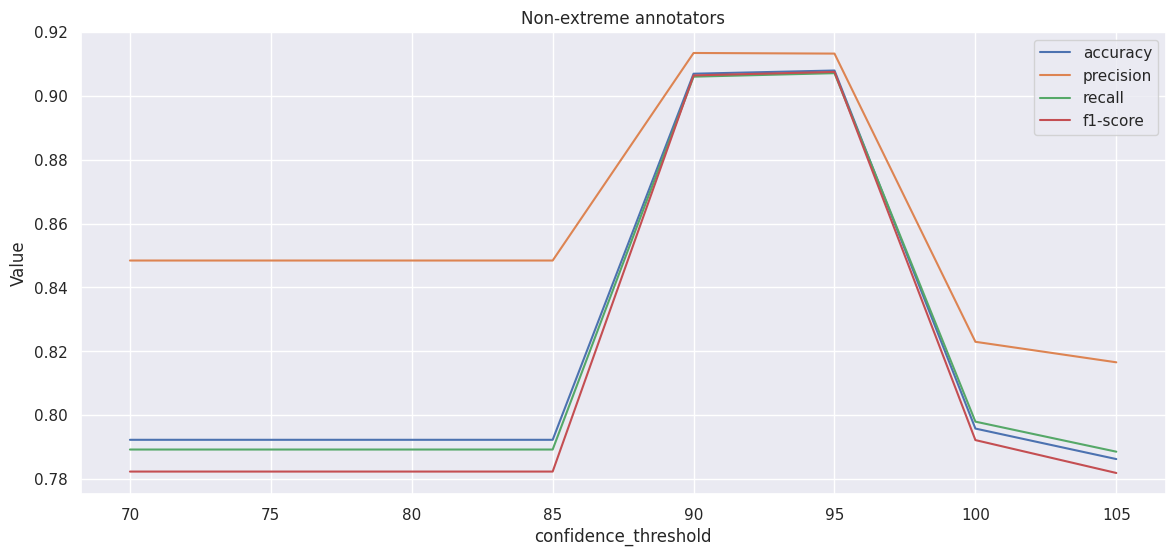

In [48]:
# All annotators.
fig = plt.figure(figsize=(14, 6))

for metric in ['accuracy', 'precision', 'recall', 'f1-score']:
    sns.lineplot(
        x=classification_metrics_mhs_majority_vote_labels['confidence_threshold'],
        y=classification_metrics_mhs_majority_vote_labels[metric],
        label=metric
    )

plt.legend()
plt.ylabel('Value')
plt.title('All annotators')


# Extreme annotators.
fig = plt.figure(figsize=(14, 6))

for metric in ['accuracy', 'precision', 'recall', 'f1-score']:
    sns.lineplot(
        x=classification_metrics_extreme_annotators_mhs_majority_vote_labels['confidence_threshold'],
        y=classification_metrics_extreme_annotators_mhs_majority_vote_labels[metric],
        label=metric
    )

plt.legend()
plt.ylabel('Value')
plt.title('Extreme annotators')


# Non-extreme annotators.
fig = plt.figure(figsize=(14, 6))

for metric in ['accuracy', 'precision', 'recall', 'f1-score']:
    sns.lineplot(
        x=classification_metrics_nonextreme_annotators_mhs_majority_vote_labels['confidence_threshold'],
        y=classification_metrics_nonextreme_annotators_mhs_majority_vote_labels[metric],
        label=metric
    )

plt.legend()
plt.ylabel('Value')
plt.title('Non-extreme annotators')

Text(0.5, 1.0, 'F1-scores against majority-vote labels (MHS data)')

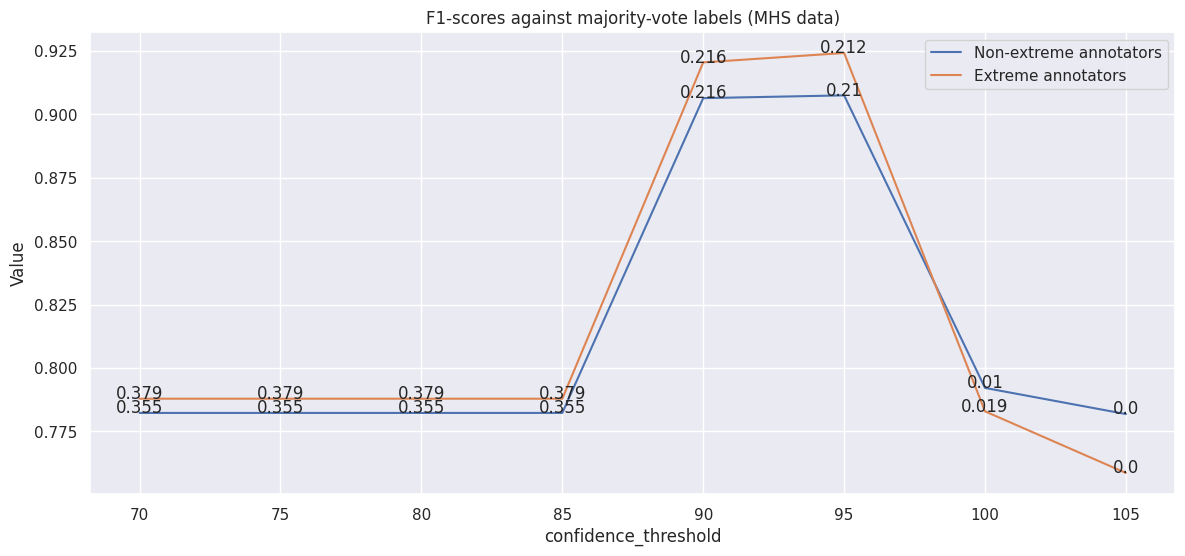

In [49]:
fig = plt.figure(figsize=(14, 6))

# sns.lineplot(
#     x=classification_metrics_kumar_majority_vote_labels['confidence_threshold'],
#     y=classification_metrics_kumar_majority_vote_labels['f1-score'],
#     label='All annotators'
# )

sns.lineplot(
    x=classification_metrics_nonextreme_annotators_mhs_majority_vote_labels['confidence_threshold'],
    y=classification_metrics_nonextreme_annotators_mhs_majority_vote_labels['f1-score'],
    label='Non-extreme annotators'
)

for i, row in classification_metrics_nonextreme_annotators_mhs_majority_vote_labels[['overridden_preds_frac', 'confidence_threshold', metric]].iterrows():
    plt.text(
        row['confidence_threshold'],
        row[metric],
        row['overridden_preds_frac'].round(3),
        horizontalalignment="center"
    )

sns.lineplot(
    x=classification_metrics_extreme_annotators_mhs_majority_vote_labels['confidence_threshold'],
    y=classification_metrics_extreme_annotators_mhs_majority_vote_labels['f1-score'],
    label='Extreme annotators'
)

for i, row in classification_metrics_extreme_annotators_mhs_majority_vote_labels[['overridden_preds_frac', 'confidence_threshold', metric]].iterrows():
    plt.text(
        row['confidence_threshold'],
        row[metric],
        row['overridden_preds_frac'].round(3),
        horizontalalignment="center"
    )

plt.legend()
plt.ylabel('Value')
plt.title('F1-scores against majority-vote labels (MHS data)')

## HateCheck data

### Load data

In [51]:
SEPHEADS_PREDICTED_LOGITS_HATECHECK_PATH = '/data1/moscato/personalised-hate-boundaries-data/models/mhs/sepheads_model_training_mhs_test_2/checkpoint_1611_hatecheck_predicted_logits.pkl'
HATECHECK_PREDICTIONS_CATALOG_PATH = '/data1/moscato/personalised-hate-boundaries-data/models/mhs/sepheads_model_training_mhs_test_2/checkpoint_1611_hatecheck_predictions_catalog.csv'
BOUNDARY_MODEL_PREDS_HATECHECK_PATH = '/data1/moscato/personalised-hate-boundaries-data/data/boundary_model_predictions/results_paul_hatecheck.csv'

In [53]:
sepheads_hatecheck_preds_df = pd.read_csv(HATECHECK_PREDICTIONS_CATALOG_PATH)

with open(SEPHEADS_PREDICTED_LOGITS_HATECHECK_PATH, 'rb') as f:
    sepheads_hatecheck_preds = pickle.load(f)

sepheads_hatecheck_preds_df['sepheads_predicted_toxic_score'] = sepheads_hatecheck_preds.argmax(axis=-1).cpu().numpy()

del sepheads_hatecheck_preds

sepheads_hatecheck_preds_df

,case_id,annotator_id,sepheads_predicted_toxic_score
0,1,20,0
1,1,23,0
2,1,28,0
3,1,38,0
4,1,39,0
...,...,...,...
2031755,3901,11018,0
2031756,3901,11062,1
2031757,3901,11111,1
2031758,3901,11122,1


In [56]:
# Load dataset.
hatecheck_data = datasets.load_dataset(
    path="Paul/hatecheck",
    cache_dir='/data1/shared_datasets/'
)['test'].to_pandas()

hatecheck_data['label_gold'] = hatecheck_data['label_gold'].map({
    'hateful': 1,
    'non-hateful': 0
})

# Attach predictions from the boundary model.
hatecheck_data = pd.concat(
    [
        hatecheck_data,
        pd.read_csv(BOUNDARY_MODEL_PREDS_HATECHECK_PATH)
    ],
    axis=1
).rename(columns={'class_label': 'boundary_model_predicted_toxic_score'})

# Correctly map the predictions from the boundary model.
hatecheck_data['boundary_model_predicted_toxic_score'] = hatecheck_data['boundary_model_predicted_toxic_score'].map({
    '1': 1,
    'yes': 1,
    'no': 0
})

# Merge data and predictions from both models.
hatecheck_data = pd.merge(
    left=sepheads_hatecheck_preds_df,
    right=hatecheck_data,
    on='case_id',
    how='left'
)

# Join with annotators data.
hatecheck_data = pd.merge(
    left=hatecheck_data,
    right=annotators_data[['annotator_id', 'extreme_annotator']],
    how='left',
    on='annotator_id'
)

In [57]:
hatecheck_data

,case_id,annotator_id,sepheads_predicted_toxic_score,functionality,test_case,label_gold,target_ident,direction,focus_words,focus_lemma,ref_case_id,ref_templ_id,templ_id,case_templ,boundary_model_predicted_toxic_score,confidence_score,extreme_annotator
0,1,20,0,derog_neg_emote_h,I hate women.,1,women,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].,1,95,False
1,1,23,0,derog_neg_emote_h,I hate women.,1,women,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].,1,95,False
2,1,28,0,derog_neg_emote_h,I hate women.,1,women,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].,1,95,False
3,1,38,0,derog_neg_emote_h,I hate women.,1,women,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].,1,95,False
4,1,39,0,derog_neg_emote_h,I hate women.,1,women,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].,1,95,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2031755,3901,11018,0,spell_leet_h,Immigrants are all complete 4ssholes.,1,immigrants,general,4ssholes,asshole,1236.0,256.0,866,[IDENTITY_P] are all complete 4ssholes.,1,95,False
2031756,3901,11062,1,spell_leet_h,Immigrants are all complete 4ssholes.,1,immigrants,general,4ssholes,asshole,1236.0,256.0,866,[IDENTITY_P] are all complete 4ssholes.,1,95,True
2031757,3901,11111,1,spell_leet_h,Immigrants are all complete 4ssholes.,1,immigrants,general,4ssholes,asshole,1236.0,256.0,866,[IDENTITY_P] are all complete 4ssholes.,1,95,False
2031758,3901,11122,1,spell_leet_h,Immigrants are all complete 4ssholes.,1,immigrants,general,4ssholes,asshole,1236.0,256.0,866,[IDENTITY_P] are all complete 4ssholes.,1,95,False


### Evaluate combined model on HateCheck

#### Global metrics

In [63]:
classification_metrics_hatecheck = []
classification_metrics_extreme_annotators_hatecheck = []
classification_metrics_nonextreme_annotators_hatecheck = []

for confidence_threshold in np.arange(70, 106, 5):
    # All annotators.
    combined_preds = compute_combined_prediction(
        sepheads_preds=hatecheck_data['sepheads_predicted_toxic_score'],
        boundary_model_preds=hatecheck_data['boundary_model_predicted_toxic_score'],
        confidence_scores=hatecheck_data['confidence_score'],
        confidence_threshold=confidence_threshold
    )
    
    hatecheck_data[f'combined_predicted_toxic_score_confidence_{confidence_threshold}'] = combined_preds

    cr = classification_report(
        hatecheck_data['label_gold'],
        combined_preds,
        digits=3,
        output_dict=True
    )

    overridden_preds_frac = (
        hatecheck_data[f'combined_predicted_toxic_score_confidence_{confidence_threshold}']
        != hatecheck_data['sepheads_predicted_toxic_score']
    ).mean()

    classification_metrics_hatecheck.append({
        'confidence_threshold': confidence_threshold,
        'overridden_preds_frac': overridden_preds_frac,
        'accuracy': cr['accuracy'],
        **cr['macro avg']
    })

    # Extreme annotators.
    cr = classification_report(
        hatecheck_data[hatecheck_data['extreme_annotator']]['label_gold'],
        hatecheck_data[hatecheck_data['extreme_annotator']][f'combined_predicted_toxic_score_confidence_{confidence_threshold}'],
        digits=3,
        output_dict=True
    )

    overridden_preds_frac = (
        hatecheck_data[hatecheck_data['extreme_annotator']][f'combined_predicted_toxic_score_confidence_{confidence_threshold}']
        != hatecheck_data[hatecheck_data['extreme_annotator']]['sepheads_predicted_toxic_score']
    ).mean()

    classification_metrics_extreme_annotators_hatecheck.append({
        'confidence_threshold': confidence_threshold,
        'overridden_preds_frac': overridden_preds_frac,
        'accuracy': cr['accuracy'],
        **cr['macro avg']
    })

    # Non-extreme annotators.
    cr = classification_report(
        hatecheck_data[~hatecheck_data['extreme_annotator']]['label_gold'],
        hatecheck_data[~hatecheck_data['extreme_annotator']][f'combined_predicted_toxic_score_confidence_{confidence_threshold}'],
        digits=3,
        output_dict=True
    )

    overridden_preds_frac = (
        hatecheck_data[~hatecheck_data['extreme_annotator']][f'combined_predicted_toxic_score_confidence_{confidence_threshold}']
        != hatecheck_data[~hatecheck_data['extreme_annotator']]['sepheads_predicted_toxic_score']
    ).mean()

    classification_metrics_nonextreme_annotators_hatecheck.append({
        'confidence_threshold': confidence_threshold,
        'overridden_preds_frac': overridden_preds_frac,
        'accuracy': cr['accuracy'],
        **cr['macro avg']
    })
    
classification_metrics_hatecheck = pd.DataFrame(classification_metrics_hatecheck)
classification_metrics_extreme_annotators_hatecheck = pd.DataFrame(classification_metrics_extreme_annotators_hatecheck)
classification_metrics_nonextreme_annotators_hatecheck = pd.DataFrame(classification_metrics_nonextreme_annotators_hatecheck)

In [64]:
# hatecheck_data.to_csv(
#     '/data1/moscato/personalised-hate-boundaries-data/data/boundary_model_predictions/combined_preds_hatecheck.csv',
#     index=None
# )

Text(0.5, 1.0, 'Non-extreme annotators')

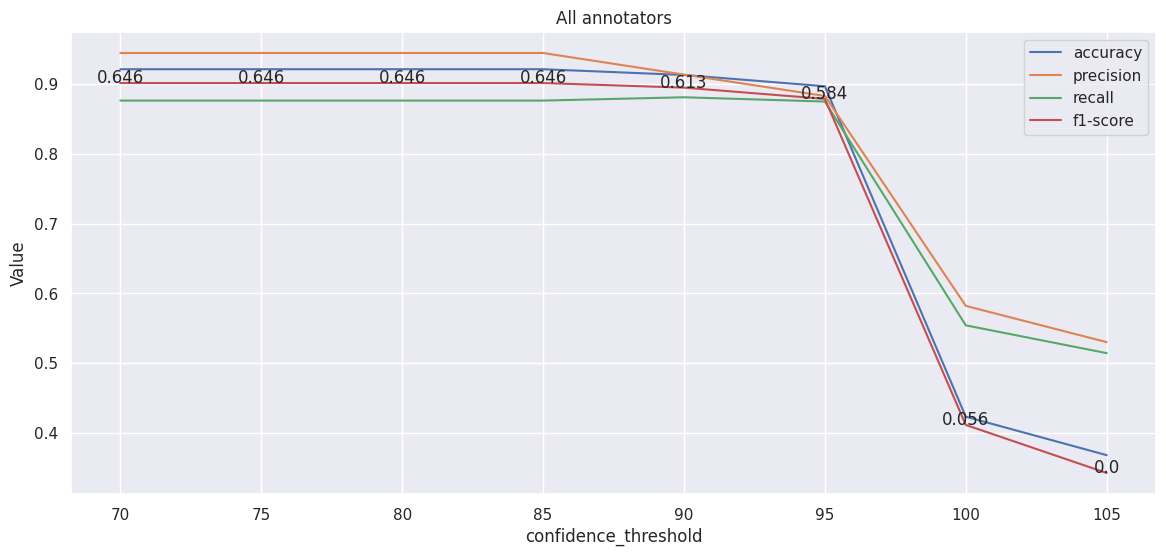

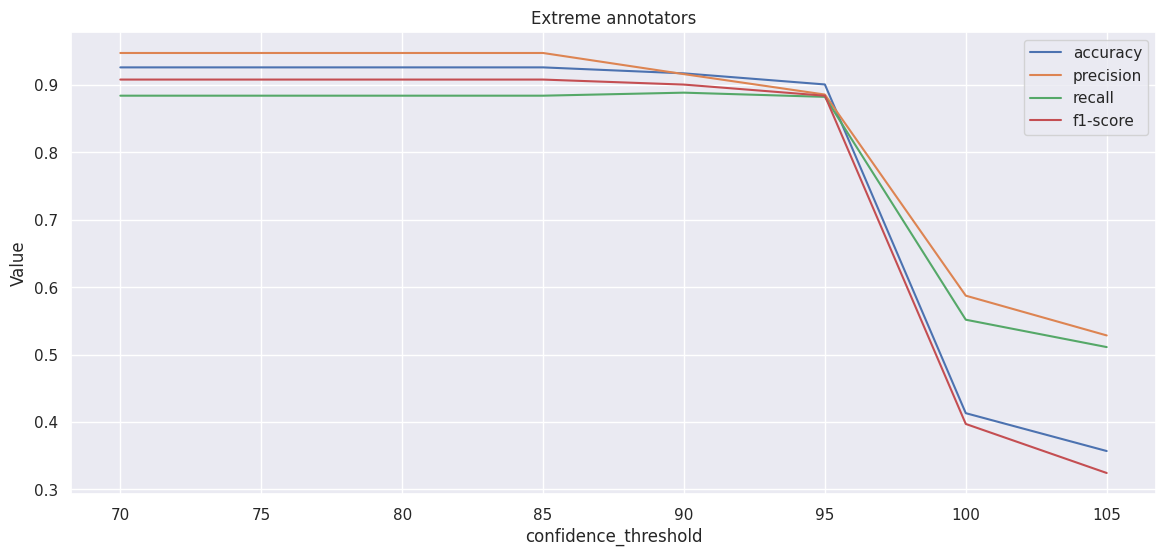

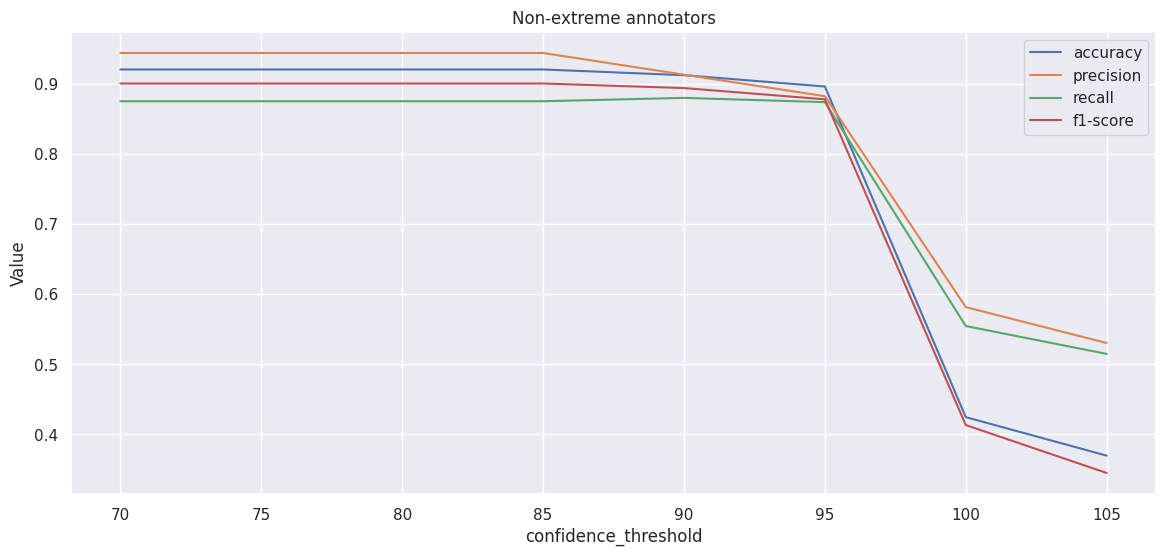

In [65]:
# All annotators.
fig = plt.figure(figsize=(14, 6))

for metric in ['accuracy', 'precision', 'recall', 'f1-score']:
    sns.lineplot(
        x=classification_metrics_hatecheck['confidence_threshold'],
        y=classification_metrics_hatecheck[metric],
        label=metric
    )

for i, row in classification_metrics_hatecheck[['overridden_preds_frac', 'confidence_threshold', metric]].iterrows():
    plt.text(
        row['confidence_threshold'],
        row[metric],
        row['overridden_preds_frac'].round(3),
        horizontalalignment="center"
    )

plt.legend()
plt.ylabel('Value')
plt.title('All annotators')


# Extreme annotators.
fig = plt.figure(figsize=(14, 6))

for metric in ['accuracy', 'precision', 'recall', 'f1-score']:
    sns.lineplot(
        x=classification_metrics_extreme_annotators_hatecheck['confidence_threshold'],
        y=classification_metrics_extreme_annotators_hatecheck[metric],
        label=metric
    )

plt.legend()
plt.ylabel('Value')
plt.title('Extreme annotators')


# Non-extreme annotators.
fig = plt.figure(figsize=(14, 6))

for metric in ['accuracy', 'precision', 'recall', 'f1-score']:
    sns.lineplot(
        x=classification_metrics_nonextreme_annotators_hatecheck['confidence_threshold'],
        y=classification_metrics_nonextreme_annotators_hatecheck[metric],
        label=metric
    )

plt.legend()
plt.ylabel('Value')
plt.title('Non-extreme annotators')

Text(0.5, 1.0, 'F1-scores against ground-truth labels (HateCheck dataset)')

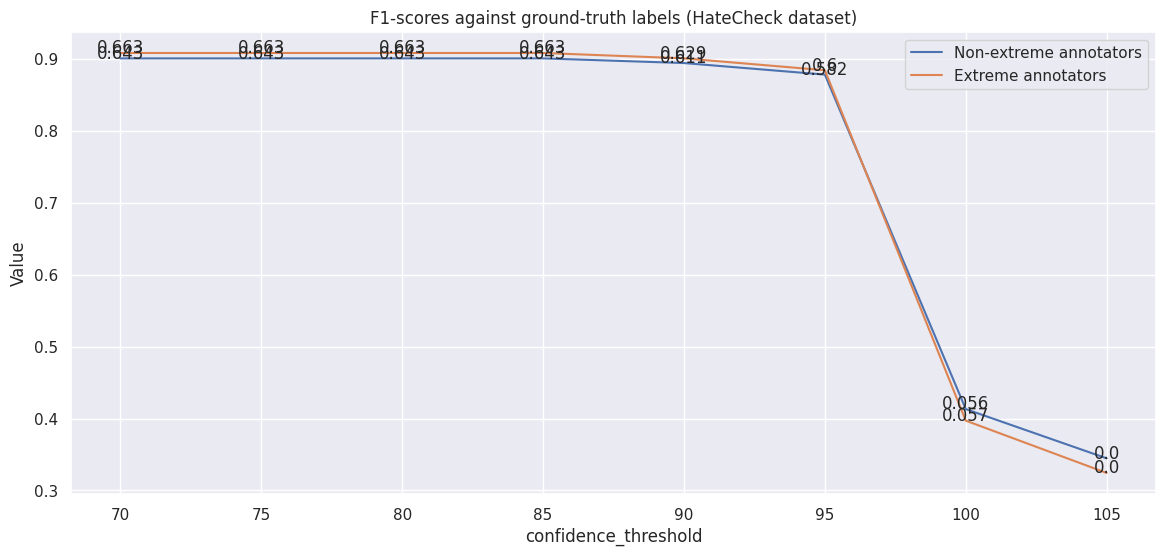

In [66]:
fig = plt.figure(figsize=(14, 6))

# sns.lineplot(
#     x=classification_metrics_hatecheck['confidence_threshold'],
#     y=classification_metrics_hatecheck['f1-score'],
#     label='All annotators'
# )

sns.lineplot(
    x=classification_metrics_nonextreme_annotators_hatecheck['confidence_threshold'],
    y=classification_metrics_nonextreme_annotators_hatecheck['f1-score'],
    label='Non-extreme annotators'
)

for i, row in classification_metrics_nonextreme_annotators_hatecheck[['overridden_preds_frac', 'confidence_threshold', metric]].iterrows():
    plt.text(
        row['confidence_threshold'],
        row[metric],
        row['overridden_preds_frac'].round(3),
        horizontalalignment="center"
    )

sns.lineplot(
    x=classification_metrics_extreme_annotators_hatecheck['confidence_threshold'],
    y=classification_metrics_extreme_annotators_hatecheck['f1-score'],
    label='Extreme annotators'
)

for i, row in classification_metrics_extreme_annotators_hatecheck[['overridden_preds_frac', 'confidence_threshold', metric]].iterrows():
    plt.text(
        row['confidence_threshold'],
        row[metric],
        row['overridden_preds_frac'].round(3),
        horizontalalignment="center"
    )

plt.legend()
plt.ylabel('Value')
plt.title('F1-scores against ground-truth labels (HateCheck dataset)')

In [67]:
classification_metrics_nonextreme_annotators_hatecheck

,confidence_threshold,overridden_preds_frac,accuracy,precision,recall,f1-score,support
0,70,0.643466,0.920650,0.944172,0.875304,0.900596,1800624.0
1,75,0.643466,0.920650,0.944172,0.875304,0.900596,1800624.0
2,80,0.643466,0.920650,0.944172,0.875304,0.900596,1800624.0
3,85,0.643466,0.920650,0.944172,0.875304,0.900596,1800624.0
4,90,0.610714,0.912478,0.913255,0.880086,0.894119,1800624.0
5,95,0.581658,0.896348,0.882516,0.873996,0.878050,1800624.0
6,100,0.055519,0.424400,0.581436,0.554408,0.413095,1800624.0
7,105,0.000000,0.369406,0.530182,0.514642,0.344665,1800624.0
